In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
# plt.style.use('default')
%config InlineBackend.figure_format = 'retina'

In [3]:
import quflow as qf

# Generate random vorticity and plot it

gamma ratio is 0.0


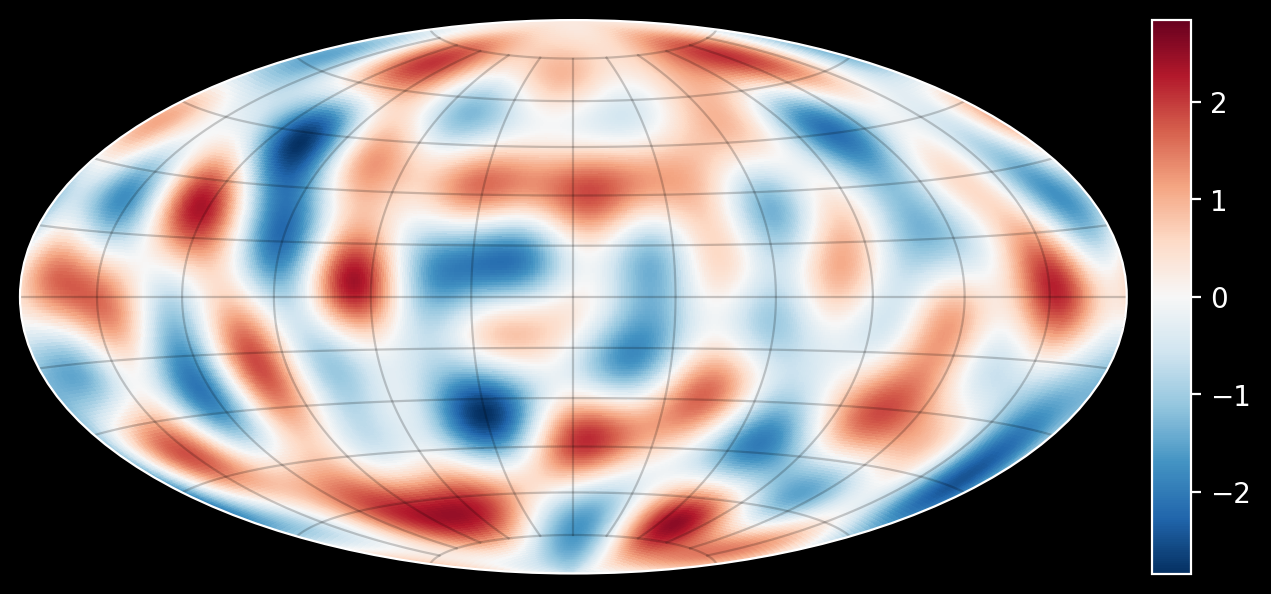

In [4]:
lmax = 10
omega0 = qf.analysis.random_shr(lmax=lmax, s=0.0, gamma=0., seed=42)
qf.plot(omega0, N=256, colorbar=True)
print("gamma ratio is {}".format(qf.analysis.gamma_ratio(omega0)))

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function (related to $\omega$ via Poisson's equation). The quantized Euler equations are similar
$$\dot W = \frac{1}{\hbar}[P,W] $$
but here the vorticity function is replaced by the vorticity matrix $W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.


## Create initial conditions

In [5]:
N = 128  # Size of matrices
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix
P0 = qf.solve_poisson(W0)
print("  L2 norm: {}\nLinf norm: {}".format(qf.geometry.norm_L2(W0), qf.geometry.norm_Linf(W0)))

  L2 norm: 1.0
Linf norm: 2.3089917367509063


## Setup simulation parameters

In [6]:
# Setup simulation
filename = "basic_sim_N_{}.hdf5".format(N)
simtime = 5.0 # in second
inner_time = 0.2 # in seconds
dt = 0.5*qf.hbar(N) # in seconds: it is a good idea to scale by hbar, to get independence of N.

# Print summary of simulation settings
print("The time step is {:.3e} seconds.".format(dt))
print("In total {} steps, with {} steps per output, and thus {} output steps.".format(round(simtime/dt), round(inner_time/dt), round(simtime/inner_time)))

The time step is 7.813e-03 seconds.
In total 640 steps, with 26 steps per output, and thus 25 output steps.


## Externally defined functions

In [7]:
# Define logger functions
# (exactly these loggers are also defined in `qf.physics.energy_euler` and `qf.physics.enstrophy`)
def energy(W):
    P = qf.solve_poisson(W)
    return -qf.geometry.inner_L2(W, P)

def enstrophy(W):
    return qf.geometry.inner_L2(W, W)

# It is a good practice to save this code as
# a string and it to the QuSimulation object.
# Then the code can easily be moved to a cluster.
prerun_code = In[len(In)-1]

## Run simulation

In [8]:
# Callback data object
mysim = qf.QuSimulation(filename, overwrite=True, state=W0, 
                        loggers={'energy':energy, 'enstrophy':enstrophy})

# Set parameters for `solve` function. This is VERY convenient when moving a 
# simulation from one computer to another.
mysim['dt'] = dt
mysim['simtime'] = simtime
mysim['inner_time'] = inner_time
mysim['integrator'] = qf.isomp
mysim['hamiltonian'] = qf.solve_poisson
mysim['prerun'] = prerun_code

# Run simulation directly from QuSimulation object
qf.solve(mysim)

# You could also run simulation using the `solve` interface 
# and with `mysim` as a callback:
# qf.solve(W0.copy(),
#          dt=dt, 
#          simtime=simtime, 
#          inner_time=inner_time, 
#          callback=mysim, 
#          integrator=qf.isomp,
#          hamiltonian=qf.solve_poisson,
#          verbatim=False
#          )


  0%|          | 0/640 [00:00<?, ? steps/s]

In [9]:
print(mysim['prerun'])

# Define logger functions
# (exactly these loggers are also defined in `qf.physics.energy_euler` and `qf.physics.enstrophy`)
def energy(W):
    P = qf.solve_poisson(W)
    return -qf.geometry.inner_L2(W, P)

def enstrophy(W):
    return qf.geometry.inner_L2(W, W)

# It is a good practice to save this code as
# a string and it to the QuSimulation object.
# Then the code can easily be moved to a cluster.


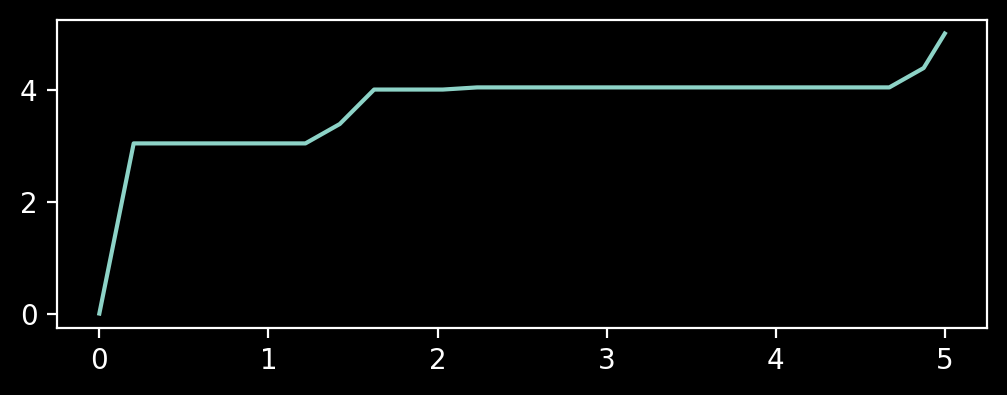

In [10]:
# Plot average number of iterations over time.
# This is a good check that everything went well 
# (you should select the time-step so that you 
# never hit `maxit` which defaults to 10).
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(mysim['time'], mysim['iterations'])

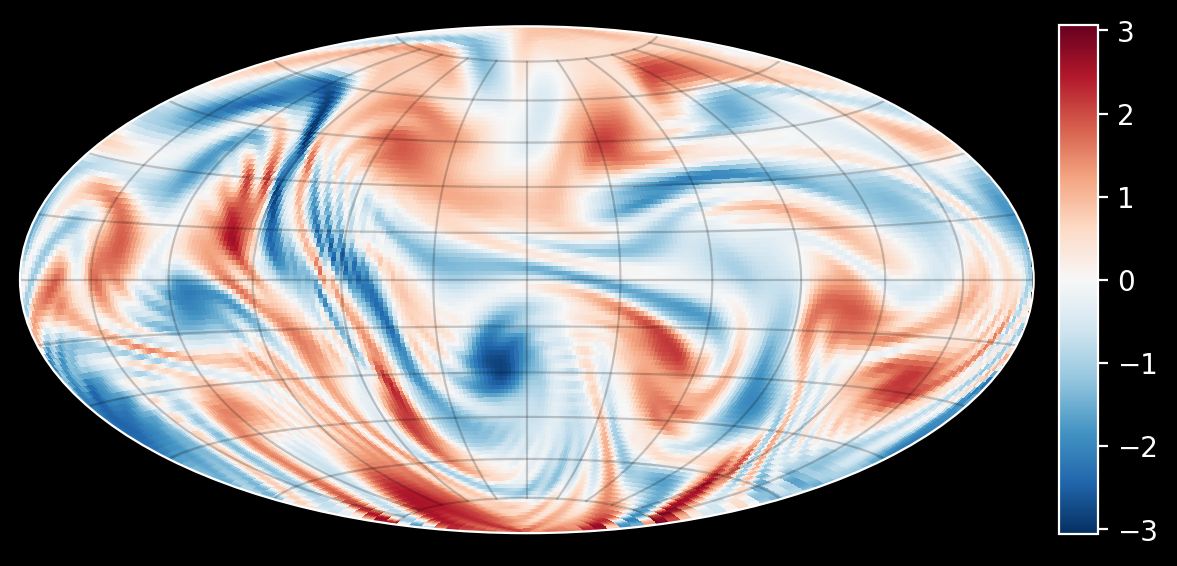

In [11]:
# Plot last state
qf.plot(mysim['fun',-1], colorbar=True)

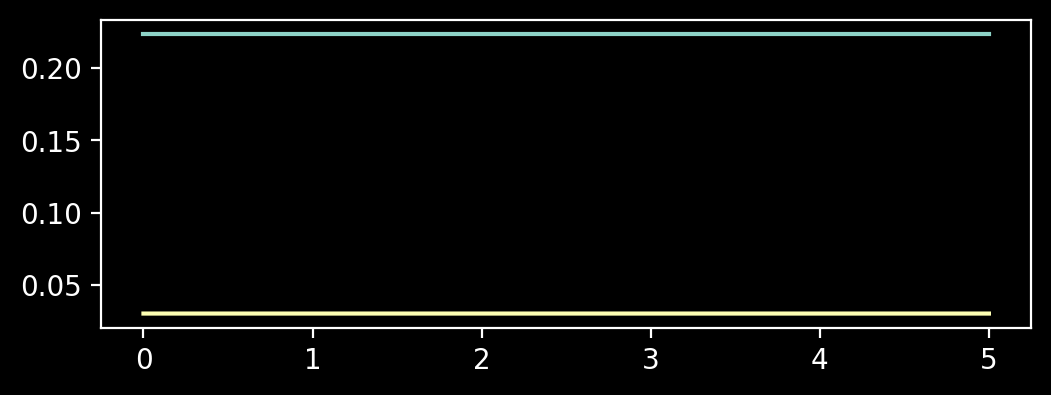

In [9]:
# Plot energy and enstrophy
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(mysim['time'], mysim['enstrophy'])
    plt.plot(mysim['time'], mysim['energy'])

## Run longer

In [33]:
# Just load the sim object, set the simulation time, and continue.
# (Notice: the simulaiton time is for the next `solve` call, not including the time
# already simulated.)
mysim = qf.QuSimulation(filename)
mysim['simtime'] = 10.0
qf.solve(mysim)

  0%|          | 0/2560 [00:00<?, ? steps/s]

100%|██████████| 2560/2560 [00:38<00:00, 65.66 steps/s]


## Animate the results

In [34]:
anim = qf.create_animation(filename.replace(".hdf5",".mp4"), mysim['fun'])
anim

100%|██████████| 128/128 [00:06<00:00, 20.41 frames/s]


## Create simulation file (for starting simulation on cluster)

In [10]:
qf.create_runfile(mysim)

# Simulation with forcing and/or Strang step

We'll now consider systems of the form
$$
\dot W = \frac{1}{\hbar}[P,W] + F(P, W)
$$
for some forcing function $F:\mathfrak{u}(N) \to \mathfrak{u}(N)$.
A particular case is the matrix Navier-Stokes equations
$$
\dot W = \frac{1}{\hbar}[P,W] + \nu \Delta_N W .
$$
The first way to introduce forcing is via the `forcing` argument to the `isomp` solver:

In [36]:
filename = "NS_forcing_sim_N_{}.hdf5".format(N)
simtime = 5.0 # in second
inner_time = 0.2 # in seconds
dt = 0.1*qf.hbar(N) # in seconds: it is a good idea to scale by hbar, to get independence of N.
nu = 0.01

def viscosity(P, W):
    DW = qf.laplacian.laplace(W)
    DW *= nu
    return DW

# Callback data object
mysim = qf.QuSimulation(filename, overwrite=True, state=W0, 
                        loggers={'energy':qf.physics.energy_euler, 'enstrophy':qf.physics.enstrophy})

# Set parameters for `solve` function. This is VERY convenient when moving a 
# simulation from one computer to another.
mysim['dt'] = dt
mysim['simtime'] = simtime
mysim['inner_time'] = inner_time
mysim['integrator'] = qf.isomp
mysim['hamiltonian'] = qf.solve_poisson
mysim['forcing'] = viscosity

qf.solve(mysim)

100%|██████████| 6400/6400 [00:50<00:00, 125.88 steps/s]


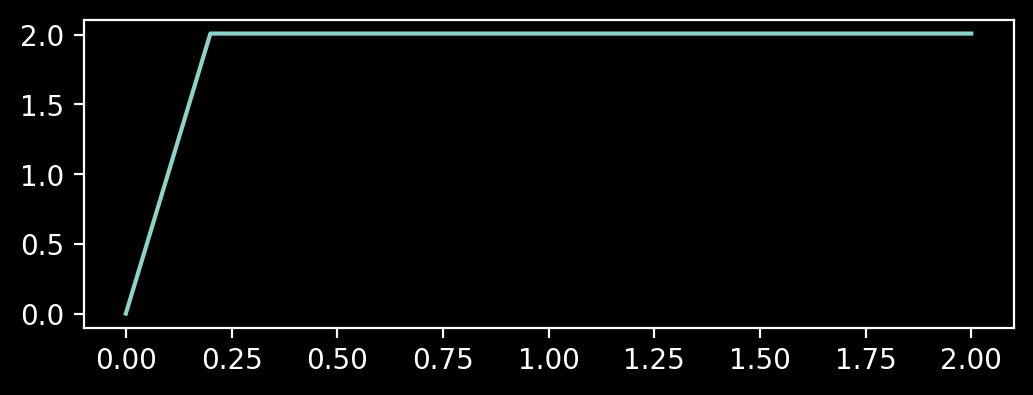

In [47]:
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(mysim['time'], mysim['iterations'])

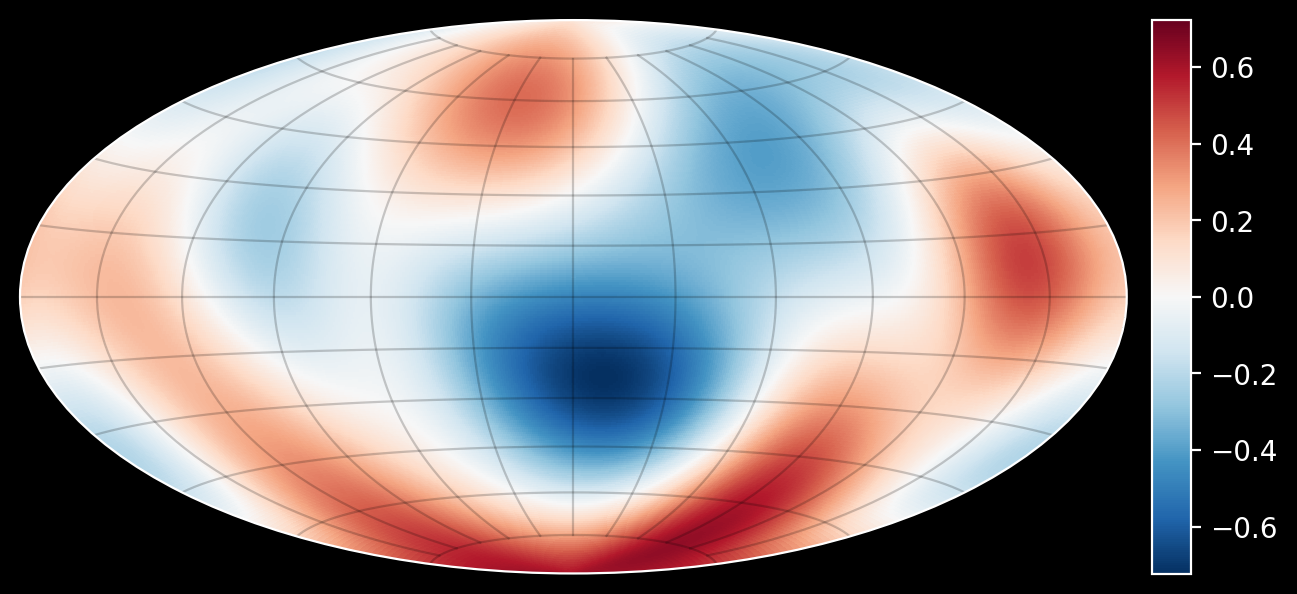

In [53]:
# Plot last state
qf.plot(mysim['fun',-1], colorbar=True)

## Animate the results

In [ ]:
anim = qf.create_animation(filename.replace(".hdf5",".mp4"), mysim['fun'])
anim

## Forcing via Strang step

The other option to introduce forcing is via a `strang_splitting` step, as follows:

In [37]:
filename = "NS_strang_sim_N_{}.hdf5".format(N)
simtime = 5.0 # in second
inner_time = 0.2 # in seconds
dt = 0.5*qf.hbar(N) # in seconds: it is a good idea to scale by hbar, to get independence of N.
nu = 0.01

def heat_flow(dt, W):
    return qf.laplacian.solve_viscdamp(dt, W, nu=nu, alpha=0, theta=0.5)

# Callback data object
mysim = qf.QuSimulation(filename, overwrite=True, state=W0, 
                        loggers={'energy':qf.physics.energy_euler, 'enstrophy':qf.physics.enstrophy})

# Set parameters for `solve` function. This is VERY convenient when moving a 
# simulation from one computer to another.
mysim['dt'] = dt
mysim['simtime'] = simtime
mysim['inner_time'] = inner_time
mysim['integrator'] = qf.isomp
mysim['hamiltonian'] = qf.solve_poisson
mysim['strang_splitting'] = heat_flow

qf.solve(mysim)

100%|██████████| 1280/1280 [00:12<00:00, 102.36 steps/s]


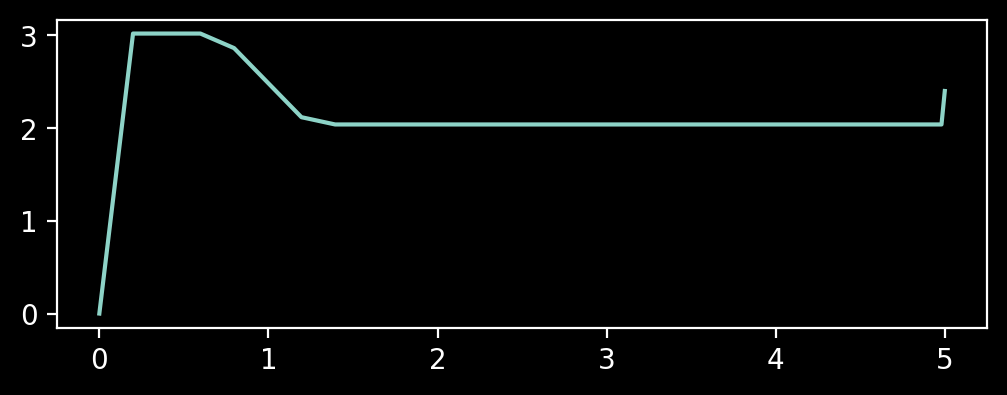

In [7]:
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(mysim['time'], mysim['iterations'])

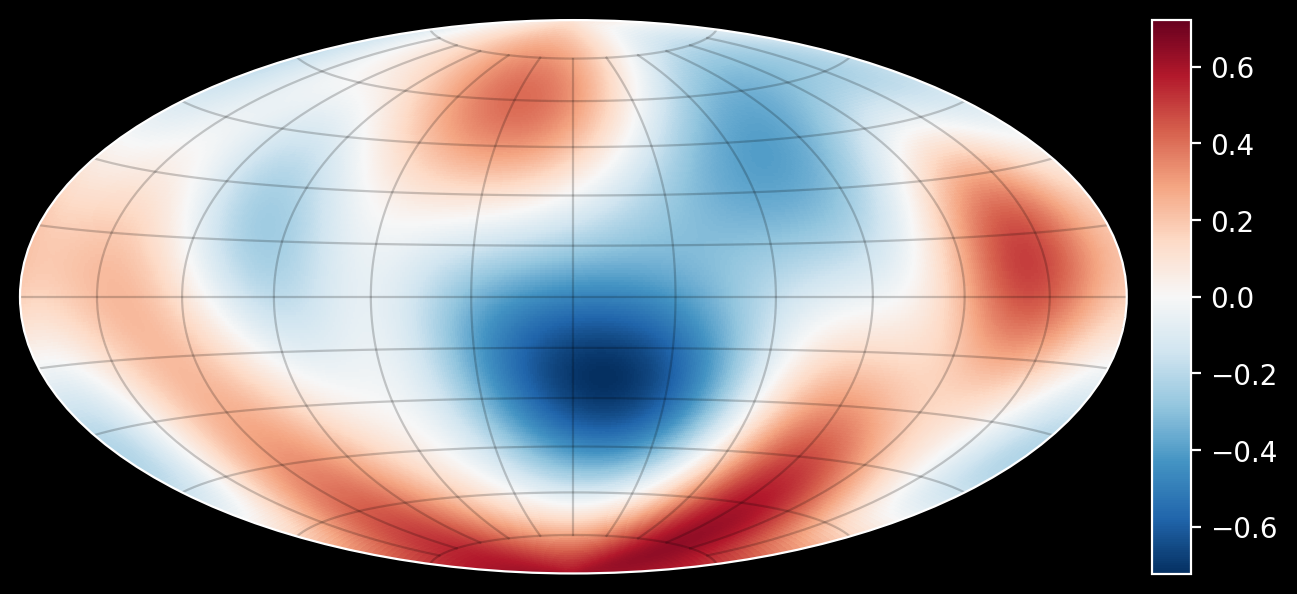

In [8]:
# Plot last state
qf.plot(mysim['fun',-1], colorbar=True)

# Non-autonomous Hamiltonian or forcing

Whenever you specify a Hamiltonian or forcing with the specific argument `time` then this is interpreted as a non-autonomous system:

In [16]:
filename = "nonautonomous_sim_N_{}.hdf5".format(N)
simtime = 15.0 # in second
inner_time = 0.2 # in seconds
dt = 0.5*qf.hbar(N) # in seconds: it is a good idea to scale by hbar, to get independence of N.

last_time = -1
last_force = np.zeros_like(W0)

def stochastic_force(P, W, time):
    global last_time, last_force
    if time != last_time:
        np.copyto(last_force, 100.0*np.sqrt(dt)*qf.shr2mat(np.random.randn(20), N=W.shape[-1]))
        last_time = time
    return last_force

# Callback data object
mysim = qf.QuSimulation(filename, overwrite=True, state=W0, 
                        loggers={'energy':qf.physics.energy_euler, 'enstrophy':qf.physics.enstrophy})

# Set parameters for `solve` function. This is VERY convenient when moving a 
# simulation from one computer to another.
mysim['dt'] = dt
mysim['simtime'] = simtime
mysim['inner_time'] = inner_time
mysim['integrator'] = qf.isomp
mysim['hamiltonian'] = qf.solve_poisson
mysim['forcing'] = stochastic_force

qf.solve(mysim)

100%|██████████| 3840/3840 [00:52<00:00, 72.83 steps/s]


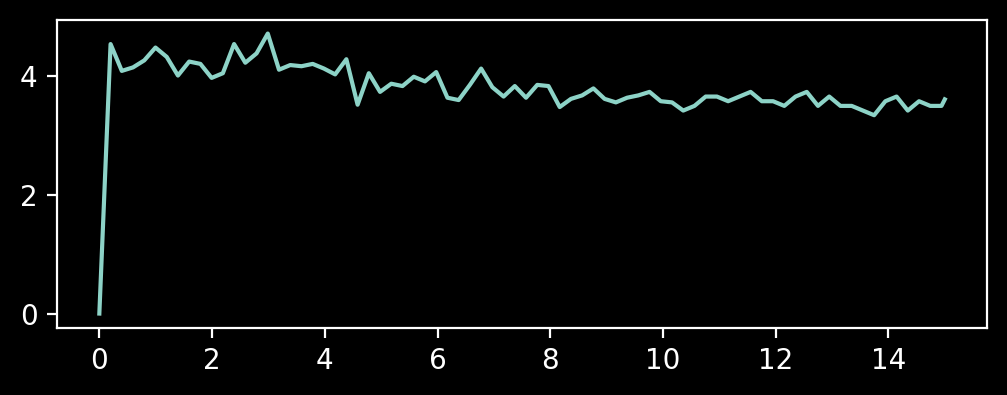

In [20]:
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(mysim['time'], mysim['iterations'])

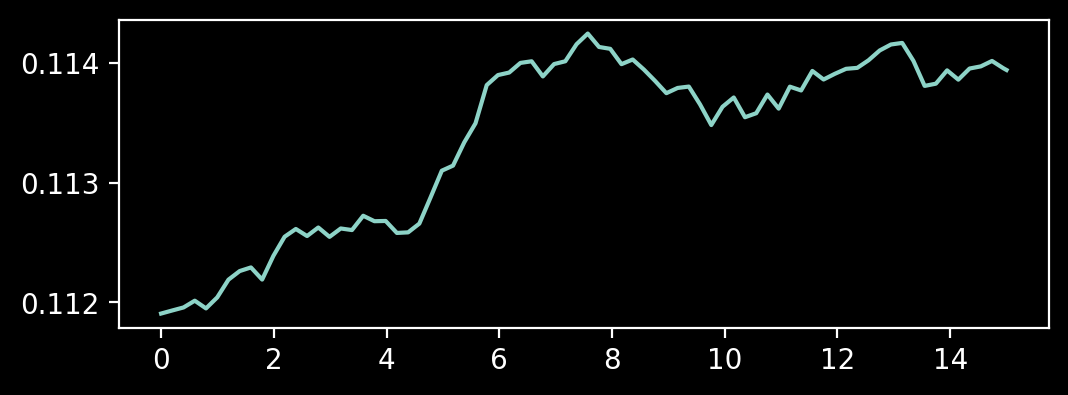

In [21]:
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(mysim['time'], mysim['enstrophy'])

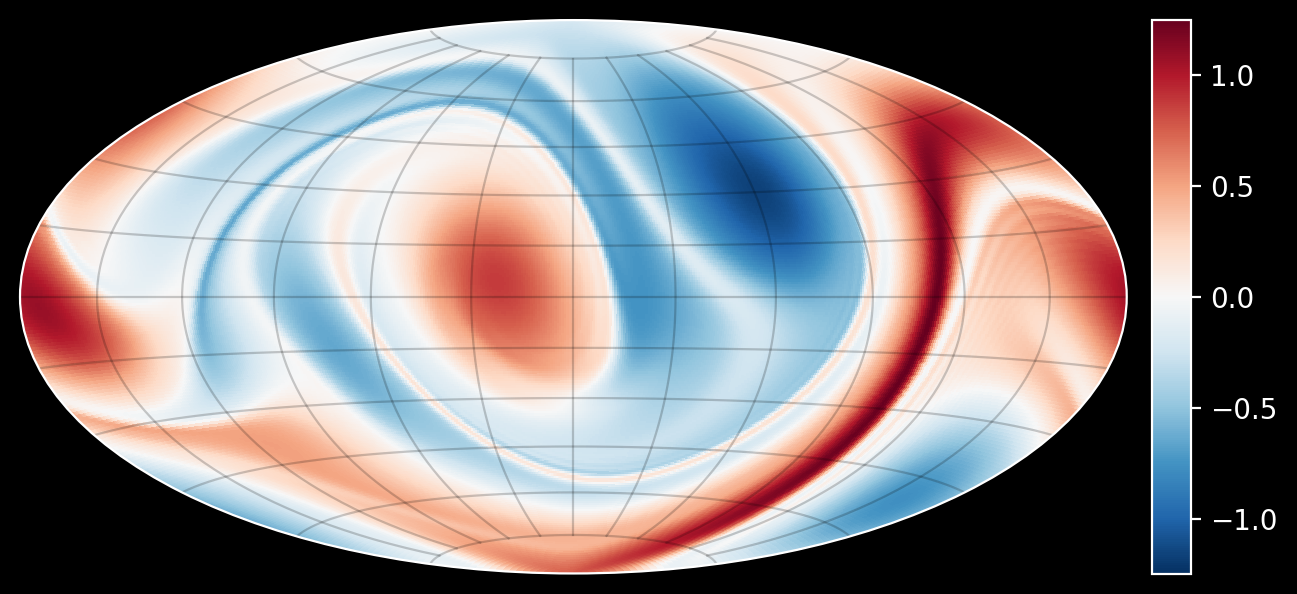

In [22]:
# Plot last state
qf.plot(mysim['fun',-1], colorbar=True)

In [17]:
# Run longer
mysim['simtime'] = 10.0
qf.solve(mysim)

100%|██████████| 2560/2560 [00:35<00:00, 73.03 steps/s]


In [23]:
anim = qf.create_animation(filename.replace(".hdf5",".mp4"), mysim['fun'])
anim

100%|██████████| 77/77 [00:03<00:00, 21.62 frames/s]


# Simulation with multiple components

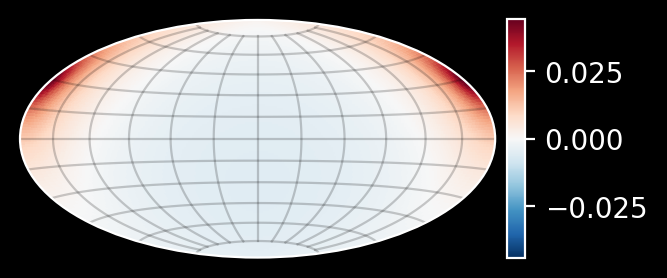

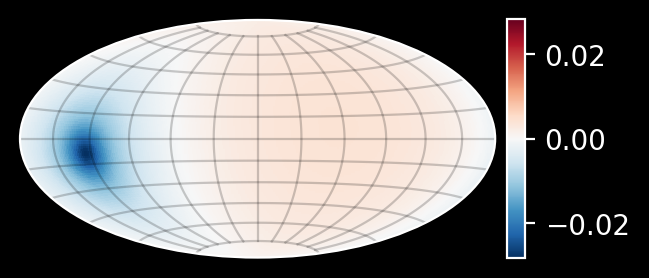

In [34]:
Theta1 = qf.dynamics.blob(N=N, pos=np.random.randn(3), sigma=3)
Theta2 = -qf.dynamics.blob(N=N, pos=np.random.randn(3), sigma=5)

with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot(Theta1, colorbar=True)
    qf.plot(Theta2, colorbar=True)

Consider the Euler equations with extra advected quantities $\Theta_1$ and $\Theta_2$
$$
    \dot W = \frac{1}{\hbar}[P, W]
$$
$$
    \dot \Theta_1 = \frac{1}{\hbar}[P, \Theta_1]
$$
$$
    \dot \Theta_2 = \frac{1}{\hbar}[P, \Theta_2]
$$
where $P = \partial_W H(W,\Theta_1,\Theta_2)$.
Consider the multicomponent state $V=[W,\Theta_1,\Theta_2]$. The Hamiltonian is then:

In [21]:
# Setup a simulation with 3 components, the first one as before, and the others some transported blobs

def multicomponent_hamiltonian(state):
    W = state[0]
    Theta1 = state[1]
    Theta2 = state[2]
    P = qf.solve_poisson(W)
    # If only one field is returned by the Hamiltonian (as here),
    # the isomp integrator interprets that as if the other fields
    # should just be transported.
    return P

state0 = np.array([W0, Theta1, Theta2])
filename_multi = "multicomponent_N_{}.hdf5".format(N)

# Define simulation object
sim_multi = qf.QuSimulation(filename_multi, overwrite=True, state=state0)

# Set `solve` arguments
sim_multi['dt'] = dt
sim_multi['simtime'] = simtime
sim_multi['inner_time'] = inner_time
sim_multi['integrator'] = qf.isomp
sim_multi['hamiltonian'] = multicomponent_hamiltonian

# Run simulation
qf.solve(sim_multi)


100%|██████████| 1280/1280 [00:39<00:00, 32.56 steps/s]


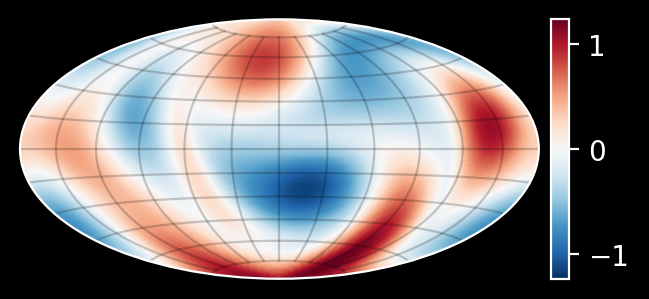

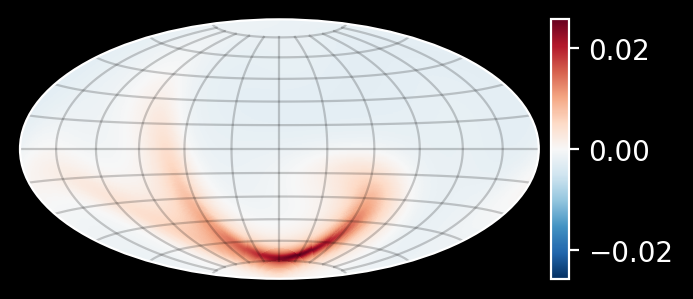

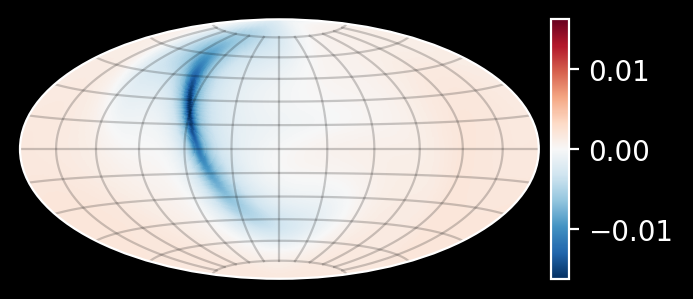

In [22]:
with plt.rc_context({'figure.figsize':(3,3)}):
    for k in range(3):
        qf.plot(sim_multi['fun',-1,k], colorbar=True)

In [24]:
anim = qf.create_animation(filename_multi.replace(".hdf5","_Theta2.mp4"), sim_multi['fun',:,2])
anim

100%|██████████| 27/27 [00:01<00:00, 21.41 frames/s]


## More advanced multicomponent: MHD

The MHD-equations are
$$
    \dot W = \frac{1}{\hbar}[P, W] {+\color{green}\frac{1}{\hbar}[B, \Theta]}
$$
$$
    \dot \Theta = \frac{1}{\hbar}[P, \Theta] \phantom{+ [M,\Theta]}
$$
Consider the multicomponent state $V=[W,\Theta]$. The Hamiltonian, returning $P$ and $B$, is then:

In [27]:
def mhd_ham(V):
    W = V[0]
    Theta = V[1]
    P = qf.solve_poisson(W)
    B = qf.laplacian.laplace(Theta)
    return P, B

We can now setup an MHD simulation, where the $W$ and $\Theta$ are blobs:

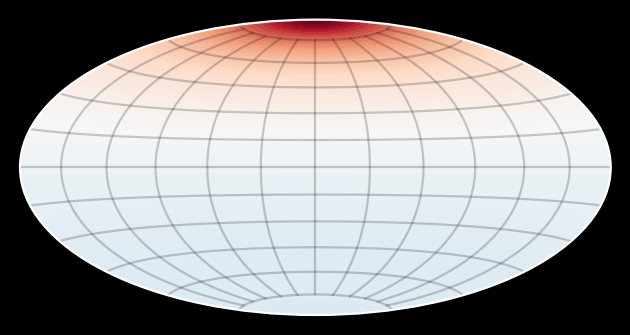

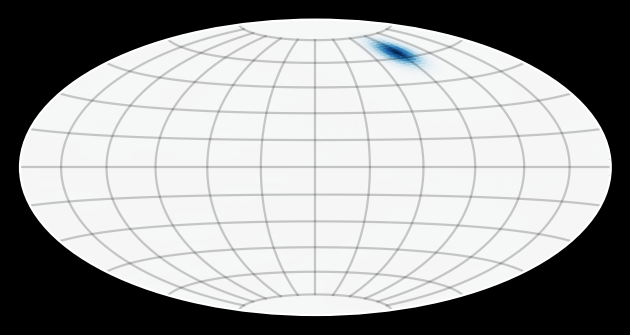

In [28]:
N = 128
W = qf.dynamics.blob(N=N, pos=np.array([0,0,-1]), sigma=5)
Theta = -qf.dynamics.blob(N=N, pos=np.array([0,1,-2]))
V0 = np.array([W,Theta])

with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot(W)
    qf.plot(Theta)

In [29]:
# MHD simulation 

filename_mhd = "mhd_N_{}.hdf5".format(N)

# Define simulation object
sim_mhd = qf.QuSimulation(filename_mhd, overwrite=True, state=V0)

# Set `solve` arguments
sim_mhd['dt'] = 0.2*qf.hbar(N)
sim_mhd['simtime'] = 25.0
sim_mhd['inner_time'] = 0.1
sim_mhd['integrator'] = qf.integrators.magmp
sim_mhd['hamiltonian'] = mhd_ham

# Run simulation
qf.solve(sim_mhd)

100%|██████████| 8000/8000 [00:48<00:00, 163.85 steps/s]


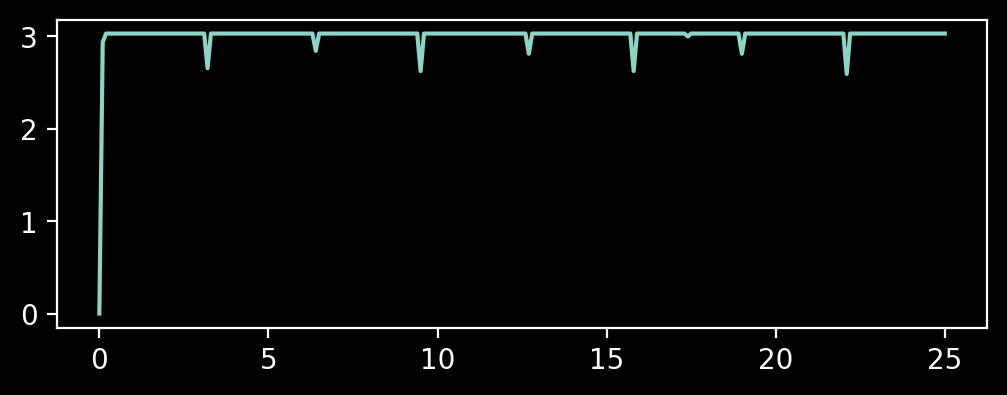

In [31]:
with plt.rc_context({'figure.figsize':(6,2)}):
    plt.plot(sim_mhd['time'],sim_mhd['iterations'])

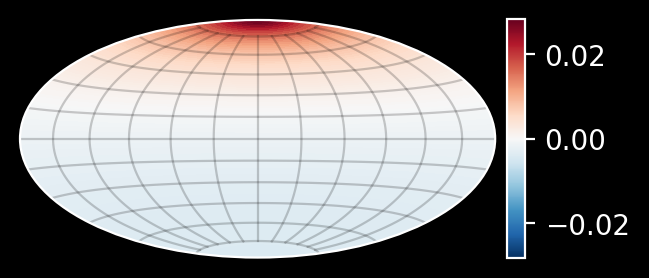

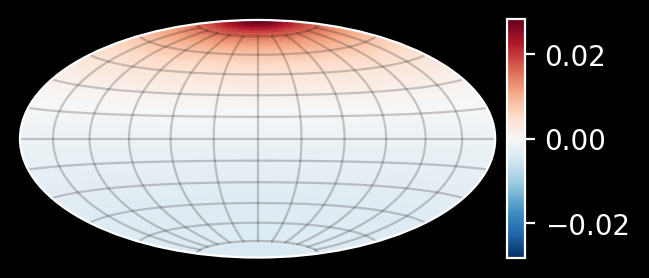

In [32]:
with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot(sim_mhd['fun',0,0],colorbar=True)
    qf.plot(sim_mhd['fun',-1,0],colorbar=True)

In [33]:
anim = qf.create_animation(filename_mhd.replace(".hdf5","_W.mp4"), sim_mhd['fun',:,0])
anim

100%|██████████| 251/251 [00:04<00:00, 54.93 frames/s]


## Even more advanced multi-component: Hazeltine's model

The Hazeltine's equations, in "canonical" form, are given by
$$
    \dot \chi = \frac{1}{\hbar}[M, \chi] {+\color{green}\frac{1}{\hbar}[B, \Theta]}
$$
$$
    \dot \Theta = \frac{1}{\hbar}[M, \Theta] \phantom{+ [M,\Theta]}
$$
$$
    \dot \Psi = \frac{1}{\hbar}[P, \Psi] \phantom{+ [M,\Theta]}
$$
where $\Psi = W - \chi$ and $M = P - \alpha \chi$.
Consider the multicomponent state $V=[\chi,\Theta,\Psi]$. The Hamiltonian, returning $[M, M, P]$ and $B$, is then:

In [3]:
alpha = 0.1

def hazeltine_ham(V):
    Chi = V[0]
    Theta = V[1]
    Psi = V[2]
    W = Psi - Chi
    P = qf.solve_poisson(W)
    M = P - alpha*Chi
    B = qf.laplacian.laplace(Theta)
    Vout = np.zeros_like(V)
    Vout[0,:,:] = M
    Vout[1,:,:] = M
    Vout[2,:,:] = P
    return Vout, B

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


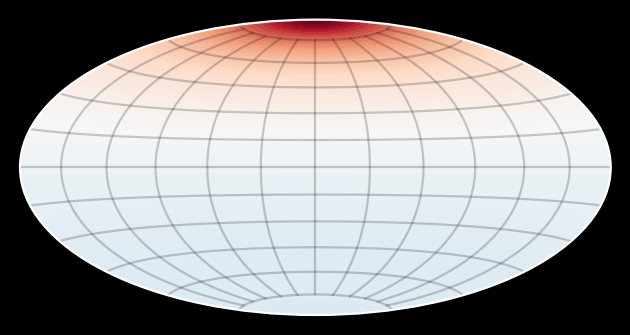

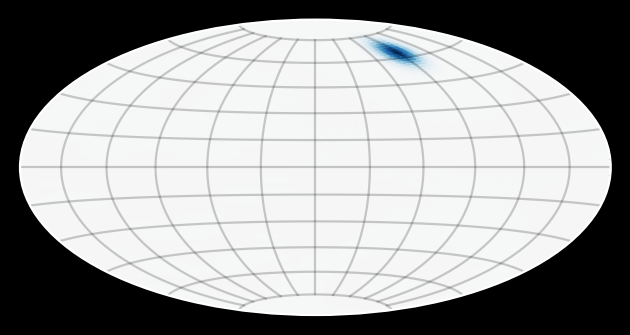

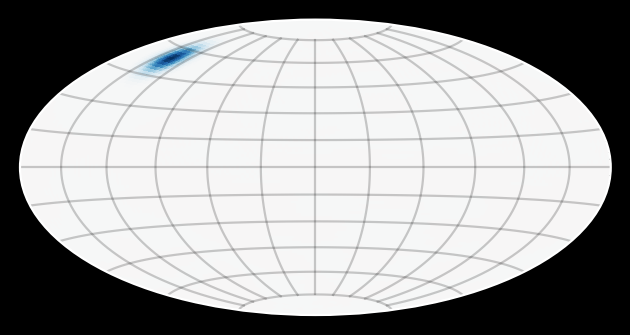

In [4]:
N = 128
Chi = qf.dynamics.blob(N=N, pos=np.array([0,0,-1]), sigma=5)
Theta = -qf.dynamics.blob(N=N, pos=np.array([0,1,-2]))
Psi = -qf.dynamics.blob(N=N, pos=np.array([1,-1,-2]))
V0 = np.array([Chi,Theta,Psi])

with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot2(Chi)
    qf.plot2(Theta)
    qf.plot2(Psi)

In [5]:
# MHD simulation 
filename_hazeltine = "hazeltine_N_{}.hdf5".format(N)

# Define simulation object
sim_hazeltine = qf.QuSimulation(filename_hazeltine, overwrite=True, state=V0)

# Set `solve` arguments
sim_hazeltine['stepsize'] = 0.2
sim_hazeltine['simtime'] = 15.0
sim_hazeltine['inner_time'] = 0.1
sim_hazeltine['integrator'] = qf.integrators.magmp
sim_hazeltine['hamiltonian'] = hazeltine_ham

# Run simulation
qf.solve(sim_hazeltine)

  0%|          | 0/4800 [00:00<?, ? steps/s]/Users/moklas/Documents/Coding/quflow/quflow/integrators/mhd.py:170: RuntimeWarning: invalid value encountered in add
  dW[0,:,:] += BThetaPhalf
/Users/moklas/Documents/Coding/quflow/quflow/integrators/mhd.py:171: RuntimeWarning: invalid value encountered in subtract
  dW[0,:,:] -= BThetaPhalf.T.conj()


ValueError: array must not contain infs or NaNs

## Compute canonical decomposition

In [25]:
[Ws,Wr] = qf.analysis.scale_decomposition(W)

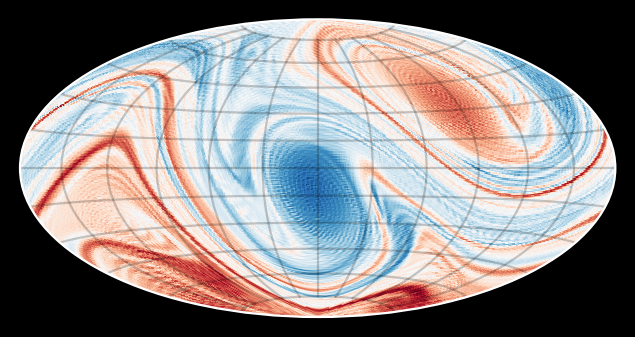

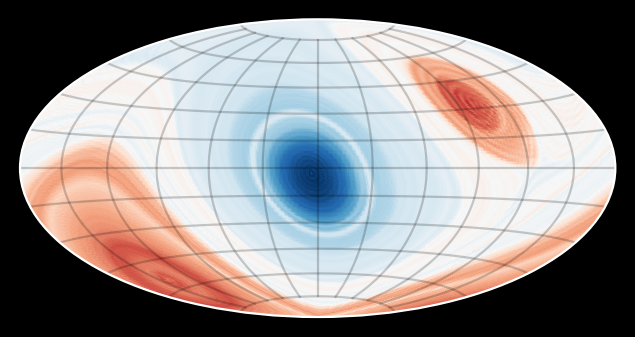

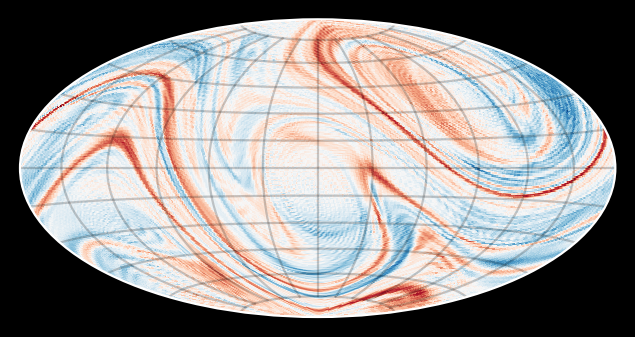

In [26]:
with plt.rc_context({'figure.figsize':(3,3)}):
    for Ww in [W, Ws, Wr]:
        qf.plot2(Ww)

## Run on cluster (OLD)

The code below should no longer be used. Instead, just copy the QuSimulation hdf5 file and start manually on the cluster.

In [8]:
import quflow.cluster as cluster

In [14]:
epsilon = 0.01

def forcing(P, W):
    Ws, Wr = qf.scale_decomposition(W, P)
    return -epsilon*Wr

force_code = In[len(In)-1]

In [15]:
# Start longer simulation on cluster
cluster.solve(filename, qstepsize=qstepsize, time=time, inner_time=inner_time, 
              method_kwargs={'forcing':forcing}, prerun=force_code,
              animate=True, simulate=True,
              upload=True, submit=True)

/Users/moklas/Documents/Coding/quflow/quflow/cluster.py:438: UserWarning: Could not establish jobstatus.
  warnings.warn("Could not establish jobstatus.")


#### CREATING RUN FILES ####
########### DONE ###########

#### UPLOADING FILES TO SERVER ####
> rsync -auv my_sim_N_128.hdf5 my_sim_N_128_run.py my_sim_N_128_submit.sh my_sim_N_128_args.pickle my_sim_N_128_cluster.pickle vera2:simulations/my_sim_N_128
building file list ... done
created directory simulations/my_sim_N_128
my_sim_N_128.hdf5
my_sim_N_128_args.pickle
my_sim_N_128_cluster.pickle
my_sim_N_128_run.py
my_sim_N_128_submit.sh

sent 7302271 bytes  received 130 bytes  14604802.00 bytes/sec
total size is 7300991  speedup is 1.00
> rsync -auv --exclude __pycache__ --exclude .DS_Store /Users/moklas/Documents/Coding/quflow/quflow vera2:simulations/my_sim_N_128
building file list ... done
quflow/
quflow/__init__.py
quflow/cluster.py
quflow/dynamics.py
quflow/graphics.py
quflow/io.py
quflow/quantization.py
quflow/splittingflow.py
quflow/transforms.py
quflow/utils.py
quflow/laplacian/
quflow/laplacian/__init__.py
quflow/laplacian/direct.py
quflow/laplacian/sparse.py
quflow/laplacian/tri

In [28]:
cluster.jobstatus()

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [27]:
# Check status
cluster.status(filename)

 Animation: 100%|##########| 79/79 [00:10<00:00,  7.24 frames/s] (jobstatus: not running)


In [29]:
cluster.retrieve(filename, onlysim=True)

> rsync -auv vera2:'simulations/my_sim_N_128/my_sim_N_128.mp4' .
receiving file list ... done
my_sim_N_128.mp4

sent 8744 bytes  received 1227898 bytes  824428.00 bytes/sec
total size is 1227463  speedup is 0.99
